# 📱 Mobile Ad Fraud Detection — Click-to-Download Prediction

**Dataset:** [TalkingData AdTracking Fraud Detection Challenge](https://www.kaggle.com/datasets/matleonard/feature-engineering-data)  
**Task:** Binary classification — predict whether a user will download an app after clicking a mobile ad  
**Model:** Logistic Regression · SVM · KNN · Decision Tree · Random Forest · Naive Bayes

---

## Table of Contents
1. [Imports & Setup](#1)
2. [Data Loading & Exploration](#2)
3. [Feature Engineering](#3)
4. [Class Imbalance & Balancing](#4)
5. [Train/Test Split & Scaling](#5)
6. [Model Training & Evaluation](#6)
   - 6.1 Logistic Regression
   - 6.2 Support Vector Machine (SVM)
   - 6.3 Decision Tree
   - 6.4 K-Nearest Neighbors (KNN)
   - 6.5 Random Forest
   - 6.6 Naive Bayes
7. [Model Comparison](#7)
8. [Decision Boundaries](#8)

---
## 1. Imports & Setup <a id='1'></a>

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.plotting import plot_decision_regions

# Aesthetics
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)
PALETTE = {
    'Logistic Regression': '#4C72B0',
    'SVM':                 '#DD8452',
    'Decision Tree':       '#55A868',
    'KNN':                 '#C44E52',
    'Random Forest':       '#8172B2',
    'Naive Bayes':         '#937860',
}
CMAP_LIST = ['Greens', 'Reds', 'Blues', 'Oranges', 'Purples', 'YlOrBr']
SEED = 42

---
## 2. Data Loading & Exploration <a id='2'></a>

In [2]:
DATA_ROOT = '/kaggle/input/datasets/neshatsharbatdar/ad-fraud-data'

df_raw = pd.read_csv(os.path.join(DATA_ROOT, 'train_sample.csv'))
print(f'Shape: {df_raw.shape}')
df_raw.info()

Shape: (2300561, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300561 entries, 0 to 2300560
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   ip               int64 
 1   app              int64 
 2   device           int64 
 3   os               int64 
 4   channel          int64 
 5   click_time       object
 6   attributed_time  object
 7   is_attributed    int64 
dtypes: int64(6), object(2)
memory usage: 140.4+ MB


In [3]:
df_raw.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,89489,3,1,13,379,2017-11-06 15:13:23,NaN,0
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1
2,3437,6,1,13,459,2017-11-06 15:42:32,NaN,0
3,167543,3,1,13,379,2017-11-06 15:56:17,NaN,0
4,147509,3,1,13,379,2017-11-06 15:57:01,NaN,0


In [4]:
# Missing values
missing = df_raw.isna().sum()
print('Missing values per column:')
print(missing[missing > 0] if missing.any() else 'None — dataset is complete ✓')

Missing values per column:
attributed_time    1843715
dtype: int64


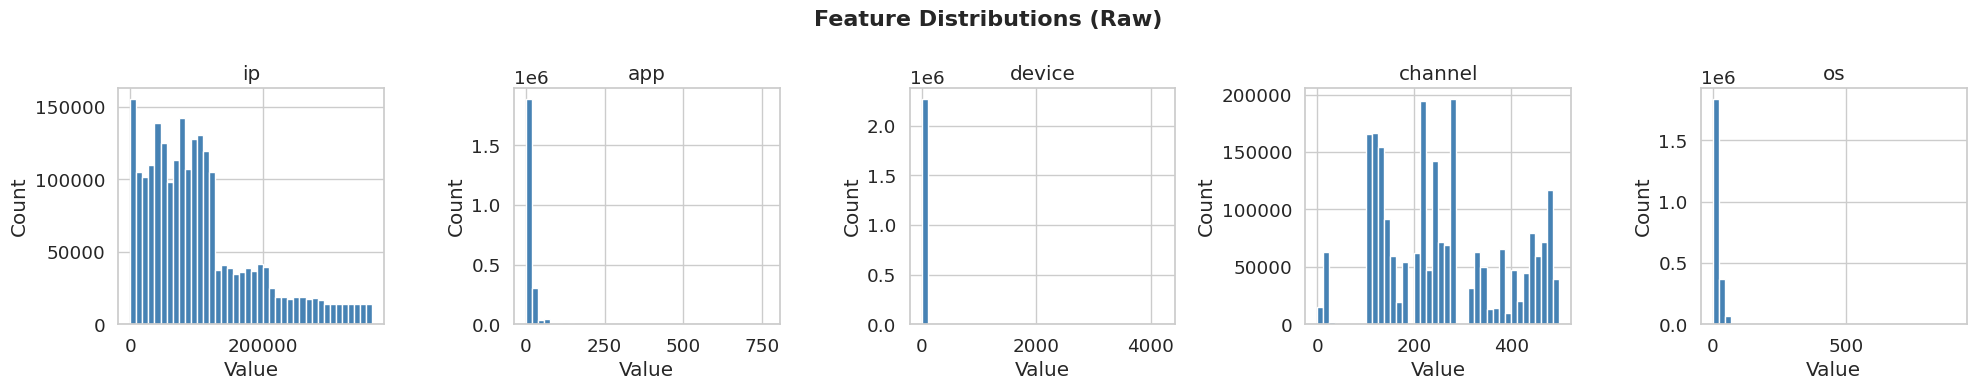

In [5]:
# Distribution of raw numeric features
num_cols = ['ip', 'app', 'device', 'channel', 'os']
fig, axes = plt.subplots(1, len(num_cols), figsize=(20, 4))
fig.suptitle('Feature Distributions (Raw)', fontsize=16, fontweight='bold')

for ax, col in zip(axes, num_cols):
    ax.hist(df_raw[col], bins=40, color='steelblue', edgecolor='white')
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.savefig('/kaggle/working/feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3. Feature Engineering <a id='3'></a>

We enrich the raw CSV with pre-computed parquet feature sets:  
- **baseline_data** — temporal features (day, hour, minute, second)  
- **catboost_encodings** — target-based encodings for categorical columns  
- **downloads / time_deltas** — aggregated click-to-download signals  

In [6]:
# Load auxiliary feature files
base_line   = pd.read_parquet(os.path.join(DATA_ROOT, 'baseline_data.pqt'))
catboost    = pd.read_parquet(os.path.join(DATA_ROOT, 'catboost_encodings.pqt'))
count_enc   = pd.read_parquet(os.path.join(DATA_ROOT, 'count_encodings.pqt'))
downloads   = pd.read_parquet(os.path.join(DATA_ROOT, 'downloads.pqt'))
interactions = pd.read_parquet(os.path.join(DATA_ROOT, 'interactions.pqt'))
time_deltas = pd.read_parquet(os.path.join(DATA_ROOT, 'time_deltas.pqt'))
svd_enc     = pd.read_parquet(os.path.join(DATA_ROOT, 'svd_encodings.pqt'))

print('Auxiliary files loaded successfully')

Auxiliary files loaded successfully


In [7]:
# Assemble final feature matrix
data = pd.read_csv(os.path.join(DATA_ROOT, 'train_sample.csv'))

# Join time-series features
for pqt_file in ['downloads.pqt', 'time_deltas.pqt']:
    feat = pd.read_parquet(os.path.join(DATA_ROOT, pqt_file))
    data = data.join(feat)

# Replace raw categoricals with CatBoost target encodings
data[['app', 'device', 'os', 'channel']] = catboost[['app_cb', 'device_cb', 'os_cb', 'channel_cb']]

# Add temporal features
data[['day', 'hour', 'minute', 'second']] = base_line[['day', 'hour', 'minute', 'second']]

# Drop non-numeric / leakage columns
data.drop(columns=['click_time', 'attributed_time'], errors='ignore', inplace=True)

print(f'Final dataset shape: {data.shape}')
data.info()

Final dataset shape: (2300561, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300561 entries, 0 to 2300560
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ip                  int64  
 1   app                 float64
 2   device              float64
 3   os                  float64
 4   channel             float64
 5   is_attributed       int64  
 6   previous_downloads  float64
 7   past_events         float64
 8   day                 uint8  
 9   hour                uint8  
 10  minute              uint8  
 11  second              uint8  
dtypes: float64(6), int64(2), uint8(4)
memory usage: 149.2 MB


In [8]:
data.head()

,ip,app,device,os,channel,is_attributed,previous_downloads,past_events,day,hour,minute,second
0,89489,0.028329,0.152087,0.138712,0.034049,0,1.0,1309.0,6,15,13,23
1,204158,0.995828,0.152087,0.138712,0.950244,1,1.0,1309.0,6,15,41,7
2,3437,0.009261,0.152087,0.138712,0.019384,0,1.0,1309.0,6,15,42,32
3,167543,0.028329,0.152087,0.138712,0.034049,0,1.0,1309.0,6,15,56,17
4,147509,0.028329,0.152087,0.138712,0.034049,0,1.0,1309.0,6,15,57,1


---
## 4. Class Imbalance & Balancing <a id='4'></a>

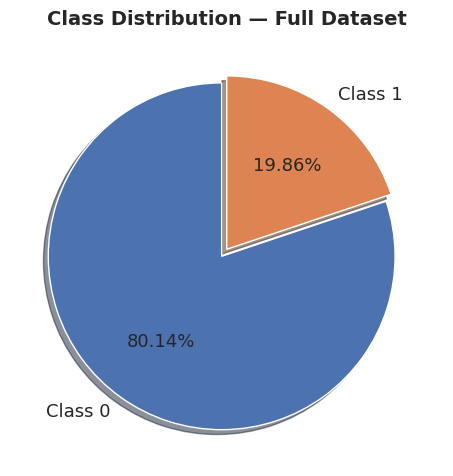

In [9]:
def plot_class_distribution(series, title):
    """Pie chart of binary class distribution."""
    counts = series.value_counts()
    labels = [f'Class {c}' for c in counts.index]
    sizes  = counts.values
    explode = (0.05, 0)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
           shadow=True, startangle=90, textprops={'fontsize': 13},
           colors=['#4C72B0', '#DD8452'])
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_class_distribution(data['is_attributed'], 'Class Distribution — Full Dataset')

---
## 5. Train / Test Split & Scaling <a id='5'></a>

Train size  (original) : 1,840,448
Train size  (balanced) : 730,954
Test  size             : 460,113

Before balancing:
is_attributed
0    1474971
1     365477
Name: count, dtype: int64

After balancing:
is_attributed
0    365477
1    365477
Name: count, dtype: int64


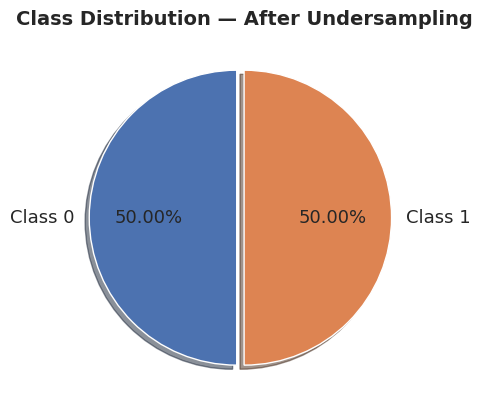

In [10]:
X = data.drop(columns='is_attributed')
y = data['is_attributed']

train_x, test_x, train_y, test_y = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Balance training set with RandomUnderSampler
sampler = RandomUnderSampler(random_state=SEED)
balanced_x, balanced_y = sampler.fit_resample(train_x, train_y)

print(f'Train size  (original) : {train_y.shape[0]:,}')
print(f'Train size  (balanced) : {balanced_y.shape[0]:,}')
print(f'Test  size             : {test_y.shape[0]:,}')
print()
print('Before balancing:')
print(train_y.value_counts())
print('\nAfter balancing:')
print(pd.Series(balanced_y).value_counts())

plot_class_distribution(pd.Series(balanced_y), 'Class Distribution — After Undersampling')

In [11]:
# Standardise
scaler = StandardScaler()
balanced_x_scaled = scaler.fit_transform(balanced_x)
test_x_scaled     = scaler.transform(test_x)
train_x_scaled    = scaler.transform(train_x)   # for train-set accuracy reporting

print('Scaling complete')

Scaling complete


---
## 6. Model Training & Evaluation <a id='6'></a>

For each model we report:
- **Train & Test Accuracy**
- **Classification Report** (precision, recall, F1)
- **Confusion Matrix**
- **ROC Curve / AUC**
- **Feature Importances** (where applicable)

In [12]:
# Reusable evaluation helper
results = {}   # stores {model_name: (fpr, tpr, auc_score)}

def evaluate_model(name, model, X_train, y_train, X_test, y_test, cmap='Blues'):
    """
    Fits model, prints accuracy on both splits, plots confusion matrix
    and ROC curve, and stores curve data in `results`.
    """
    model.fit(X_train, y_train)

    train_acc = model.score(X_train, y_train) * 100
    test_acc  = model.score(X_test, y_test)  * 100
    y_pred    = model.predict(X_test)

    print(f'\n{'='*55}')
    print(f'  {name}')
    print(f'{'='*55}')
    print(f'  Train Accuracy : {train_acc:.2f}%')
    print(f'  Test  Accuracy : {test_acc:.2f}%')
    print()
    print(classification_report(y_test, y_pred, target_names=['No Download (0)', 'Download (1)']))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, ax=ax,
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    ax.set_title(f'{name} — Confusion Matrix', fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/cm_{name.replace(" ", "_").lower()}.png', dpi=150, bbox_inches='tight')
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc     = auc(fpr, tpr)
    results[name] = (fpr, tpr, roc_auc)

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(fpr, tpr, color=PALETTE.get(name, 'steelblue'),
            lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    ax.plot([0, 0, 1], [0, 1, 1], ':', color='green', label='Perfect Classifier')
    ax.plot([0, 1], [0, 1], '--', color='grey', label='Random Classifier')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{name} — ROC Curve', fontweight='bold')
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/roc_{name.replace(" ", "_").lower()}.png', dpi=150, bbox_inches='tight')
    plt.show()

    return model

### 6.1 Logistic Regression


  Logistic Regression
  Train Accuracy : 90.92%
  Test  Accuracy : 95.14%

                 precision    recall  f1-score   support

No Download (0)       0.96      0.98      0.97    368744
   Download (1)       0.91      0.84      0.87     91369

       accuracy                           0.95    460113
      macro avg       0.93      0.91      0.92    460113
   weighted avg       0.95      0.95      0.95    460113



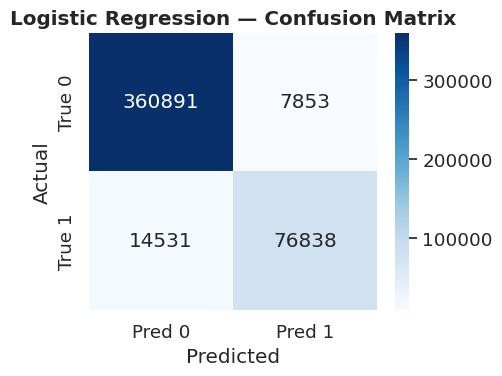

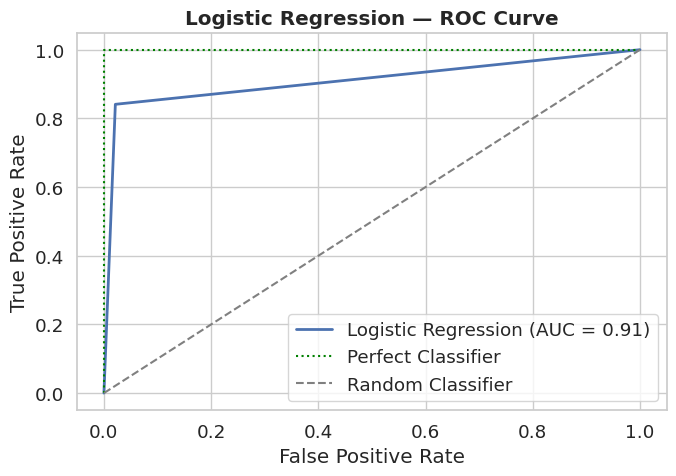

In [13]:
lr = evaluate_model(
    'Logistic Regression',
    LogisticRegression(max_iter=1000, random_state=SEED),
    balanced_x_scaled, balanced_y,
    test_x_scaled, test_y,
    cmap='Blues'
)

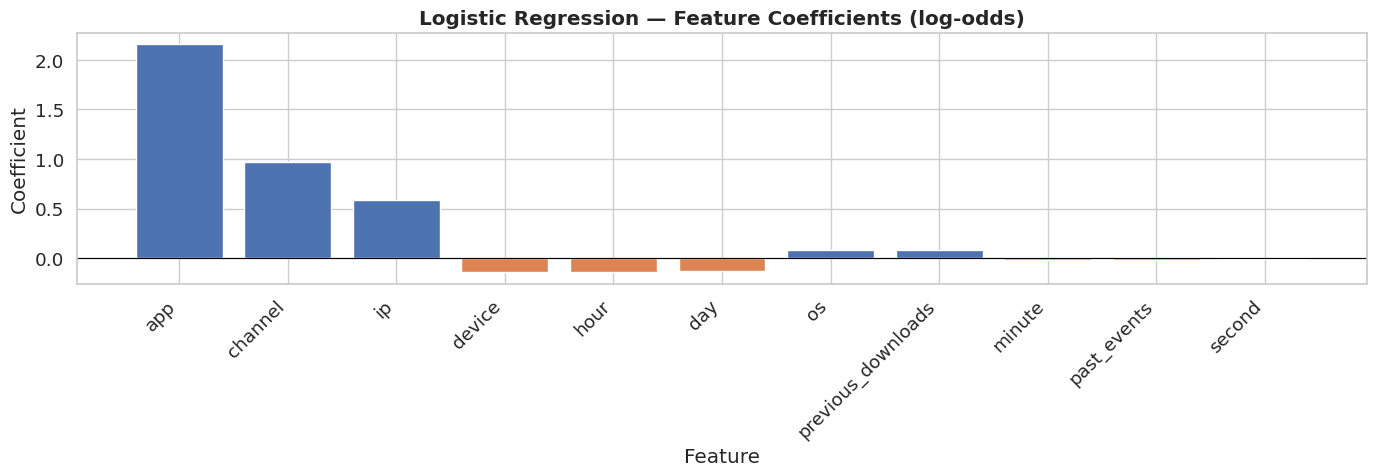

In [14]:
# Feature coefficients (log-odds)
coef = lr.coef_[0]
feat_names = X.columns

sorted_idx = np.argsort(np.abs(coef))[::-1]
fig, ax = plt.subplots(figsize=(14, 5))
colors = ['#4C72B0' if c > 0 else '#DD8452' for c in coef[sorted_idx]]
ax.bar(feat_names[sorted_idx], coef[sorted_idx], color=colors)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Logistic Regression — Feature Coefficients (log-odds)', fontweight='bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/kaggle/working/lr_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.2 Support Vector Machine (SVM)


  SVM
  Train Accuracy : 92.00%
  Test  Accuracy : 94.19%

                 precision    recall  f1-score   support

No Download (0)       0.96      0.97      0.96    368744
   Download (1)       0.87      0.84      0.85     91369

       accuracy                           0.94    460113
      macro avg       0.91      0.90      0.91    460113
   weighted avg       0.94      0.94      0.94    460113



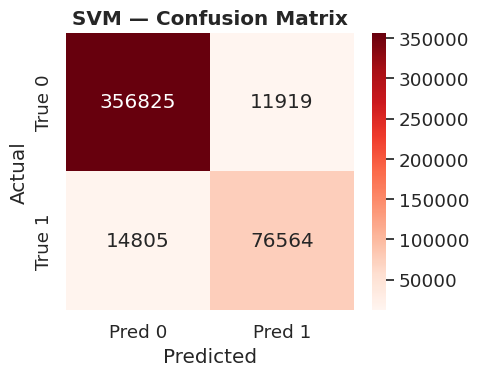

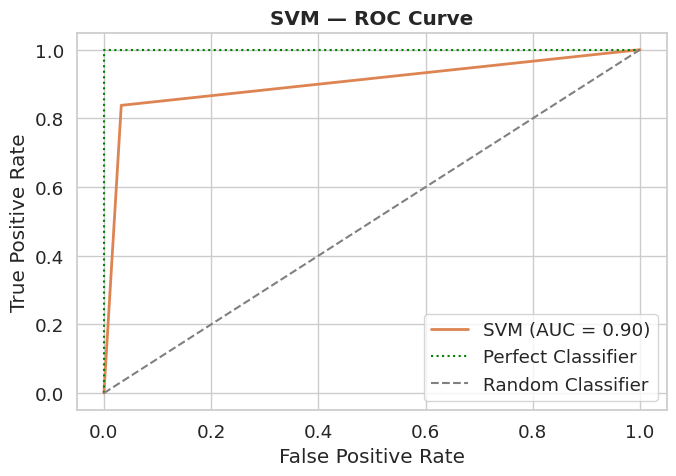

In [15]:
# SVM is slow on large data — subsample for training
SVM_SAMPLE = 300   # 150 per class
svm_df = pd.DataFrame(balanced_x_scaled, columns=X.columns)
svm_df['target'] = balanced_y.values

svm_sample = pd.concat([
    svm_df[svm_df['target'] == 0].sample(SVM_SAMPLE // 2, random_state=SEED),
    svm_df[svm_df['target'] == 1].sample(SVM_SAMPLE // 2, random_state=SEED)
])
s_x = svm_sample.drop(columns='target').values
s_y = svm_sample['target'].values

svm = evaluate_model(
    'SVM',
    SVC(kernel='linear', random_state=SEED),
    s_x, s_y,
    test_x_scaled, test_y,
    cmap='Reds'
)

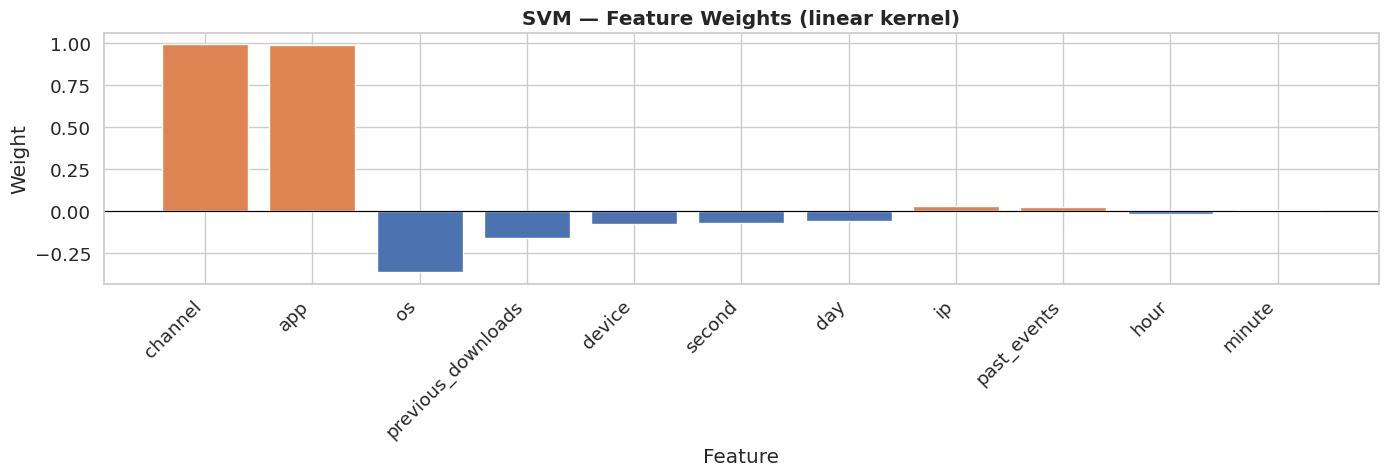

In [16]:
# SVM feature weights
coef_svm = svm.coef_[0]
sorted_idx = np.argsort(np.abs(coef_svm))[::-1]
colors = ['#DD8452' if c > 0 else '#4C72B0' for c in coef_svm[sorted_idx]]

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(feat_names[sorted_idx], coef_svm[sorted_idx], color=colors)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('SVM — Feature Weights (linear kernel)', fontweight='bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Weight')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/kaggle/working/svm_weights.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.3 Decision Tree


  Decision Tree
  Train Accuracy : 92.32%
  Test  Accuracy : 94.46%

                 precision    recall  f1-score   support

No Download (0)       0.97      0.96      0.97    368744
   Download (1)       0.84      0.89      0.86     91369

       accuracy                           0.94    460113
      macro avg       0.91      0.92      0.91    460113
   weighted avg       0.95      0.94      0.95    460113



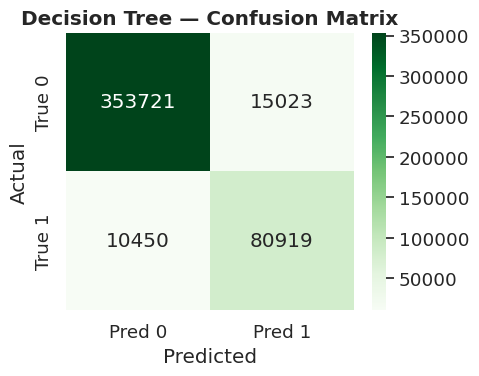

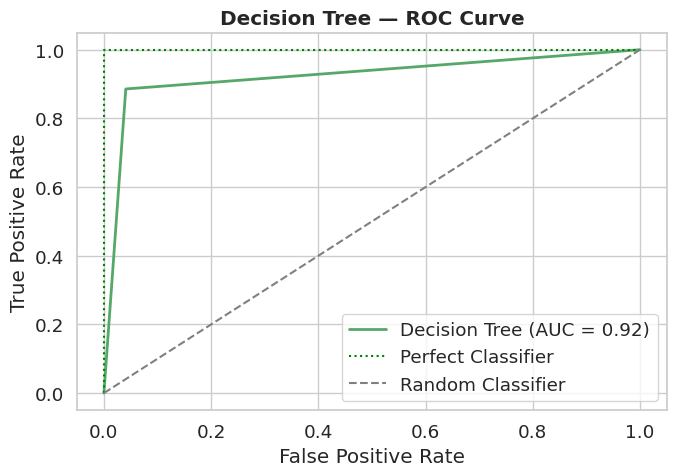

In [17]:
dt = evaluate_model(
    'Decision Tree',
    DecisionTreeClassifier(random_state=SEED, max_depth=10),
    balanced_x_scaled, balanced_y,
    test_x_scaled, test_y,
    cmap='Greens'
)

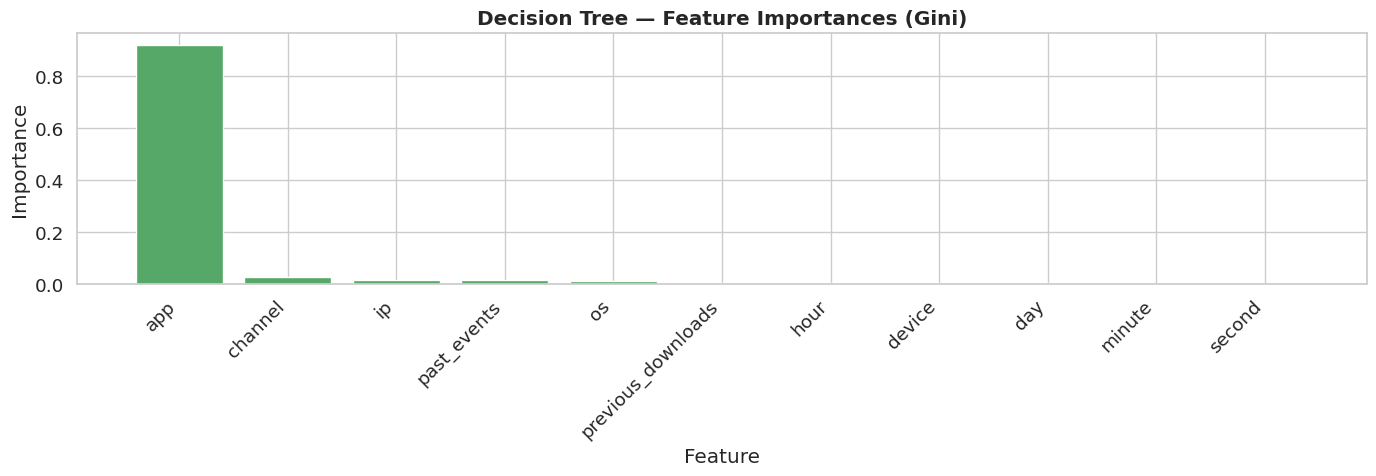

In [18]:
# Feature importances
importances = dt.feature_importances_
sorted_idx  = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(feat_names[sorted_idx], importances[sorted_idx], color='#55A868')
ax.set_title('Decision Tree — Feature Importances (Gini)', fontweight='bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/kaggle/working/dt_importances.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.4 K-Nearest Neighbors (KNN)

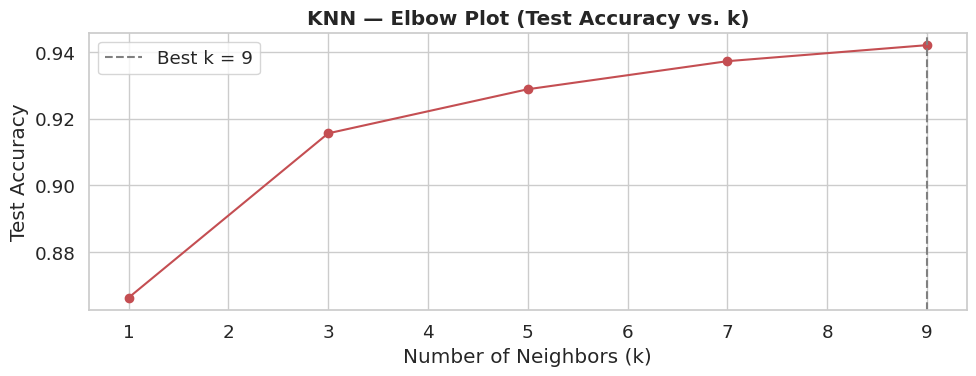

Best k = 9


In [19]:
# Elbow plot — fast version using subsample + n_jobs=-1
sample_idx = np.random.choice(len(test_x_scaled), 5000, replace=False)
X_sample = test_x_scaled[sample_idx]
y_sample = test_y.iloc[sample_idx]

k_range = range(1, 11, 2)  # only 1,3,5,7,9
k_scores = []
for k in k_range:
    knn_tmp = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn_tmp.fit(balanced_x_scaled, balanced_y)
    k_scores.append(knn_tmp.score(X_sample, y_sample))

best_k = list(k_range)[np.argmax(k_scores)]
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(k_range, k_scores, marker='o', color='#C44E52')
ax.axvline(best_k, color='grey', linestyle='--', label=f'Best k = {best_k}')
ax.set_title('KNN — Elbow Plot (Test Accuracy vs. k)', fontweight='bold')
ax.set_xlabel('Number of Neighbors (k)')
ax.set_ylabel('Test Accuracy')
ax.legend()
plt.tight_layout()
plt.savefig('/kaggle/working/knn_elbow.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Best k = {best_k}')


  KNN
  Train Accuracy : 92.02%
  Test  Accuracy : 93.85%

                 precision    recall  f1-score   support

No Download (0)       0.97      0.96      0.96      8015
   Download (1)       0.83      0.87      0.85      1985

       accuracy                           0.94     10000
      macro avg       0.90      0.91      0.91     10000
   weighted avg       0.94      0.94      0.94     10000



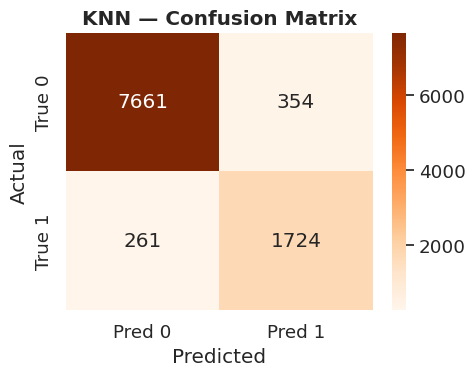

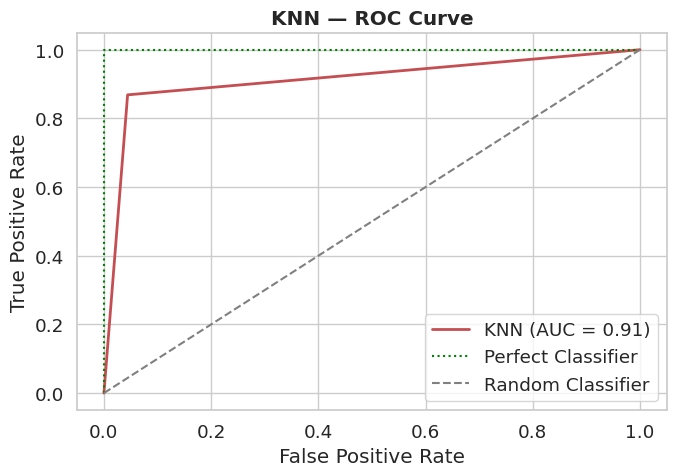

In [20]:
# KNN evaluate on subsample (too slow on full 460k test set)
# Note: KNN evaluated on 10k random test samples due to computational constraints.
# KNN prediction time scales with dataset size (O(n)), making full evaluation impractical.
sample_idx = np.random.choice(len(test_x_scaled), 10000, replace=False)
X_test_knn = test_x_scaled[sample_idx]
y_test_knn = test_y.iloc[sample_idx]

knn = evaluate_model(
    'KNN',
    KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1),
    balanced_x_scaled, balanced_y,
    X_test_knn, y_test_knn,
    cmap='Oranges'
)

### 6.5 Random Forest


  Random Forest
  Train Accuracy : 100.00%
  Test  Accuracy : 94.85%

                 precision    recall  f1-score   support

No Download (0)       0.97      0.96      0.97    368744
   Download (1)       0.85      0.89      0.87     91369

       accuracy                           0.95    460113
      macro avg       0.91      0.93      0.92    460113
   weighted avg       0.95      0.95      0.95    460113



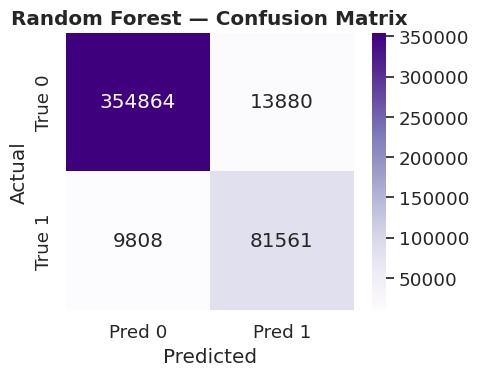

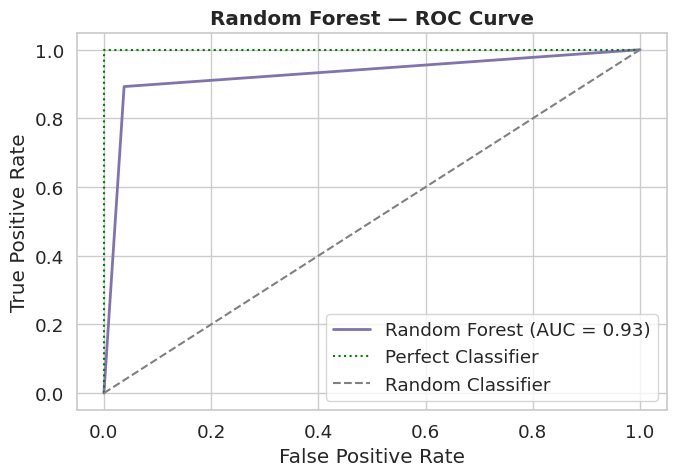

In [21]:
rf = evaluate_model(
    'Random Forest',
    RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1),
    balanced_x_scaled, balanced_y,
    test_x_scaled, test_y,
    cmap='Purples'
)

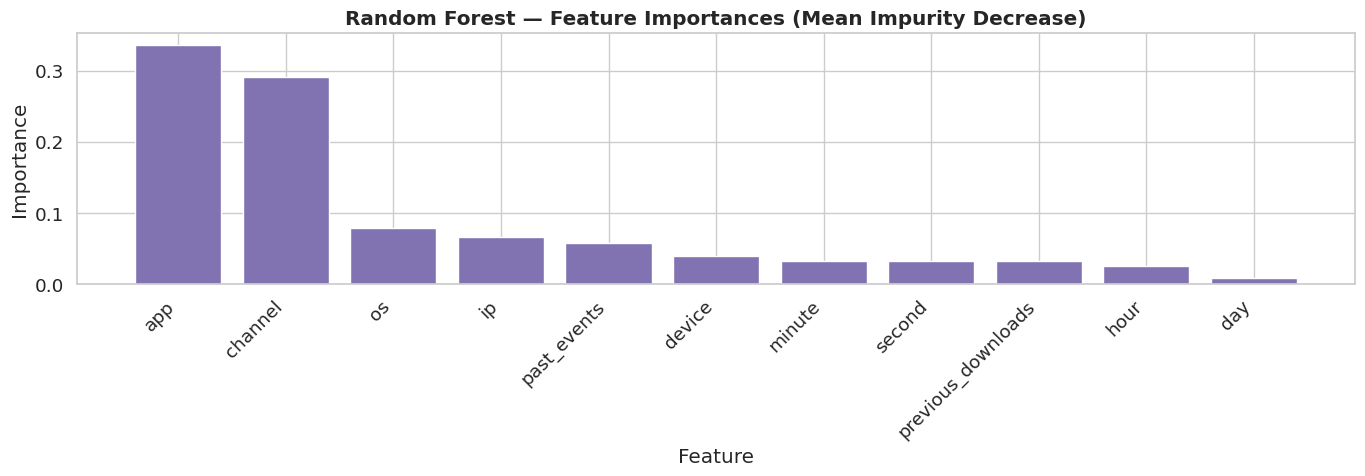

In [22]:
# Feature importances
importances = rf.feature_importances_
sorted_idx  = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(feat_names[sorted_idx], importances[sorted_idx], color='#8172B2')
ax.set_title('Random Forest — Feature Importances (Mean Impurity Decrease)', fontweight='bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/kaggle/working/rf_importances.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.6 Naive Bayes


  Naive Bayes
  Train Accuracy : 90.02%
  Test  Accuracy : 93.63%

                 precision    recall  f1-score   support

No Download (0)       0.96      0.96      0.96    368744
   Download (1)       0.84      0.84      0.84     91369

       accuracy                           0.94    460113
      macro avg       0.90      0.90      0.90    460113
   weighted avg       0.94      0.94      0.94    460113



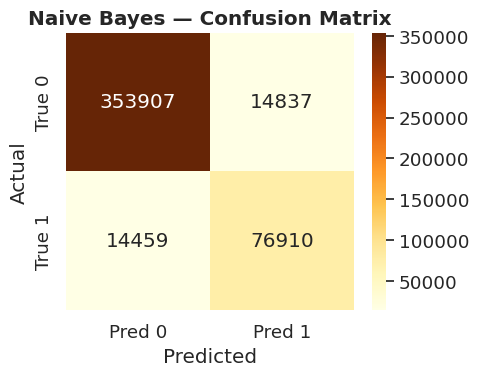

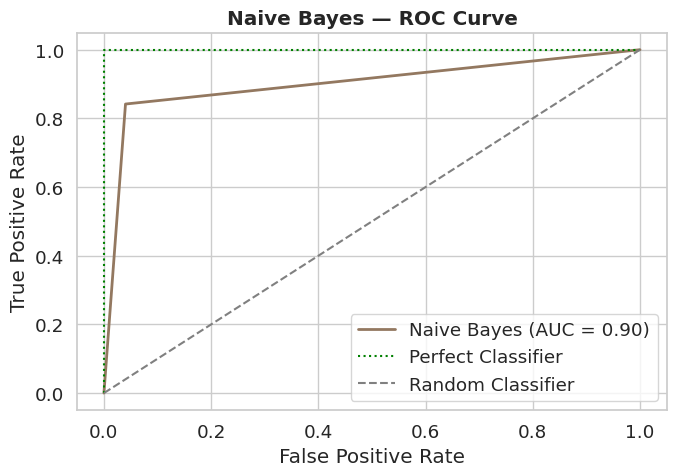

In [23]:
nb = evaluate_model(
    'Naive Bayes',
    GaussianNB(),
    balanced_x_scaled, balanced_y,
    test_x_scaled, test_y,
    cmap='YlOrBr'
)

---
## 7. Model Comparison <a id='7'></a>

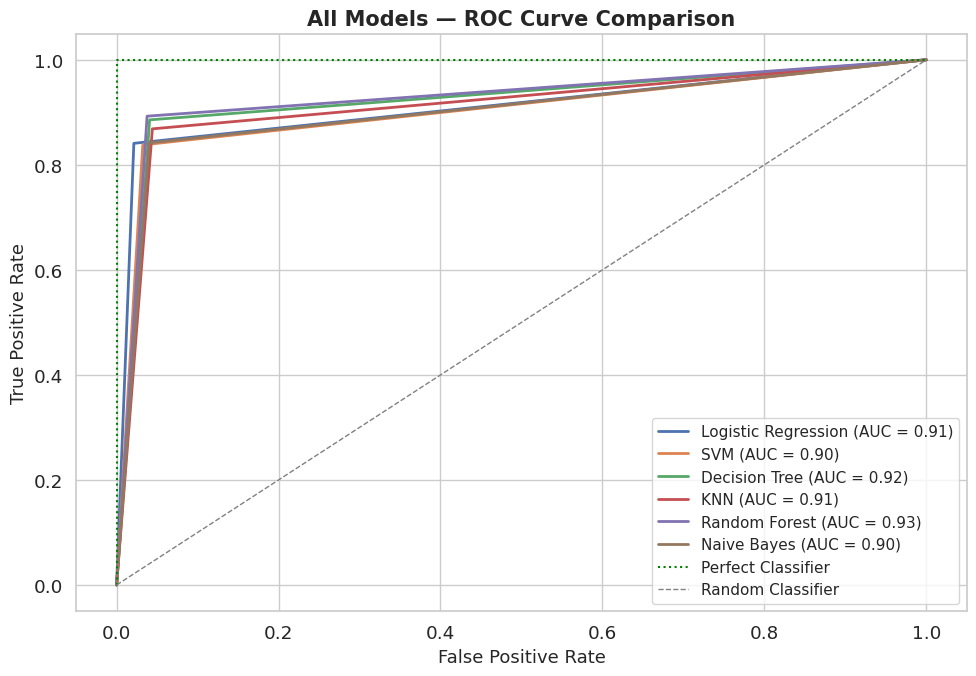

In [24]:
# Combined ROC Curve
fig, ax = plt.subplots(figsize=(10, 7))

for name, (fpr, tpr, roc_auc) in results.items():
    ax.plot(fpr, tpr, lw=2, color=PALETTE.get(name),
            label=f'{name} (AUC = {roc_auc:.2f})')

ax.plot([0, 0, 1], [0, 1, 1], ':', color='green',  lw=1.5, label='Perfect Classifier')
ax.plot([0, 1],    [0, 1],    '--', color='grey', lw=1,   label='Random Classifier')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=13)
ax.set_ylabel('True Positive Rate',  fontsize=13)
ax.set_title('All Models — ROC Curve Comparison', fontsize=15, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
plt.tight_layout()
plt.savefig('/kaggle/working/roc_all_models.png', dpi=150, bbox_inches='tight')
plt.show()

In [26]:
models = {
    'Logistic Regression': lr,
    'SVM':                 svm,
    'Decision Tree':       dt,
    'KNN':                 knn,
    'Random Forest':       rf,
    'Naive Bayes':         nb,
}

In [27]:
# Summary table — use stored results to avoid re-scoring
summary_rows = []
for name, model in models.items():
    # Train accuracy
    if name == 'SVM':
        tr_acc = model.score(s_x, s_y) * 100
    elif name == 'KNN':
        tr_acc = model.score(balanced_x_scaled, balanced_y) * 100
        te_acc = model.score(X_test_knn, y_test_knn) * 100  # use same subsample as evaluation
    else:
        tr_acc = model.score(balanced_x_scaled, balanced_y) * 100

    # Test accuracy — reuse predictions already stored in results
    if name != 'KNN':
        te_acc = model.score(test_x_scaled, test_y) * 100

    _, _, roc_auc = results[name]
    summary_rows.append({
        'Model':        name,
        'Train Acc (%)': round(tr_acc, 2),
        'Test Acc (%)':  round(te_acc, 2),
        'AUC':           round(roc_auc, 4)
    })

summary_df = pd.DataFrame(summary_rows).sort_values('AUC', ascending=False).reset_index(drop=True)
summary_df

,Model,Train Acc (%),Test Acc (%),AUC
0,Random Forest,100.00,94.85,0.9275
1,Decision Tree,92.32,94.46,0.9224
2,KNN,92.02,93.85,0.9122
3,Logistic Regression,90.92,95.14,0.9098
4,SVM,92.00,94.19,0.9028
5,Naive Bayes,90.02,93.63,0.9008


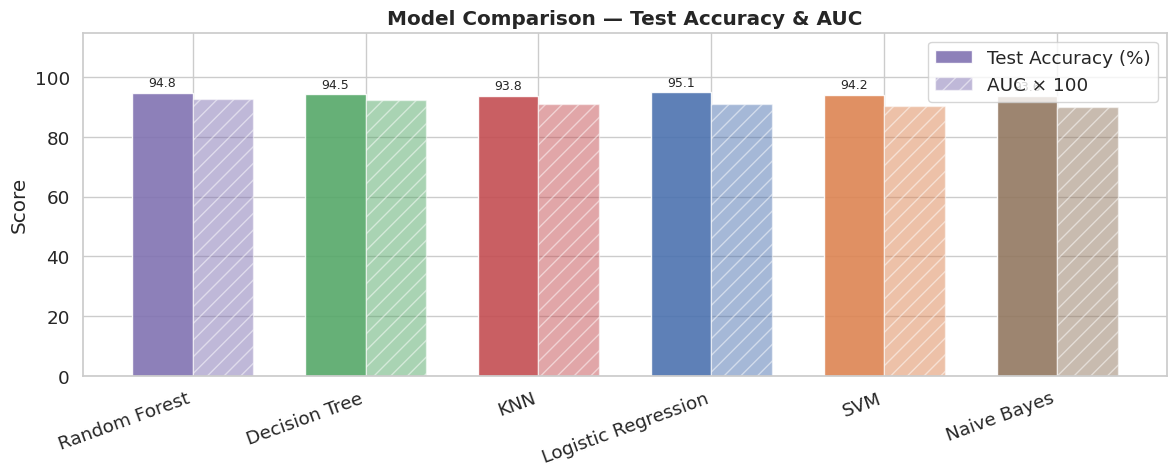

In [28]:
# Bar chart: Test Accuracy & AUC side by side
x = np.arange(len(summary_df))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 5))
bars1 = ax.bar(x - width/2, summary_df['Test Acc (%)'], width, label='Test Accuracy (%)',
               color=[PALETTE[m] for m in summary_df['Model']], alpha=0.9)
bars2 = ax.bar(x + width/2, summary_df['AUC'] * 100, width, label='AUC × 100',
               color=[PALETTE[m] for m in summary_df['Model']], alpha=0.5, hatch='//')

ax.set_xticks(x)
ax.set_xticklabels(summary_df['Model'], rotation=20, ha='right')
ax.set_ylabel('Score')
ax.set_title('Model Comparison — Test Accuracy & AUC', fontweight='bold')
ax.legend()
ax.set_ylim(0, 115)
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig('/kaggle/working/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Decision Boundaries <a id='8'></a>

We project onto the two most important features (`channel` × `app`) from the balanced training set to visualise how each classifier partitions the feature space.

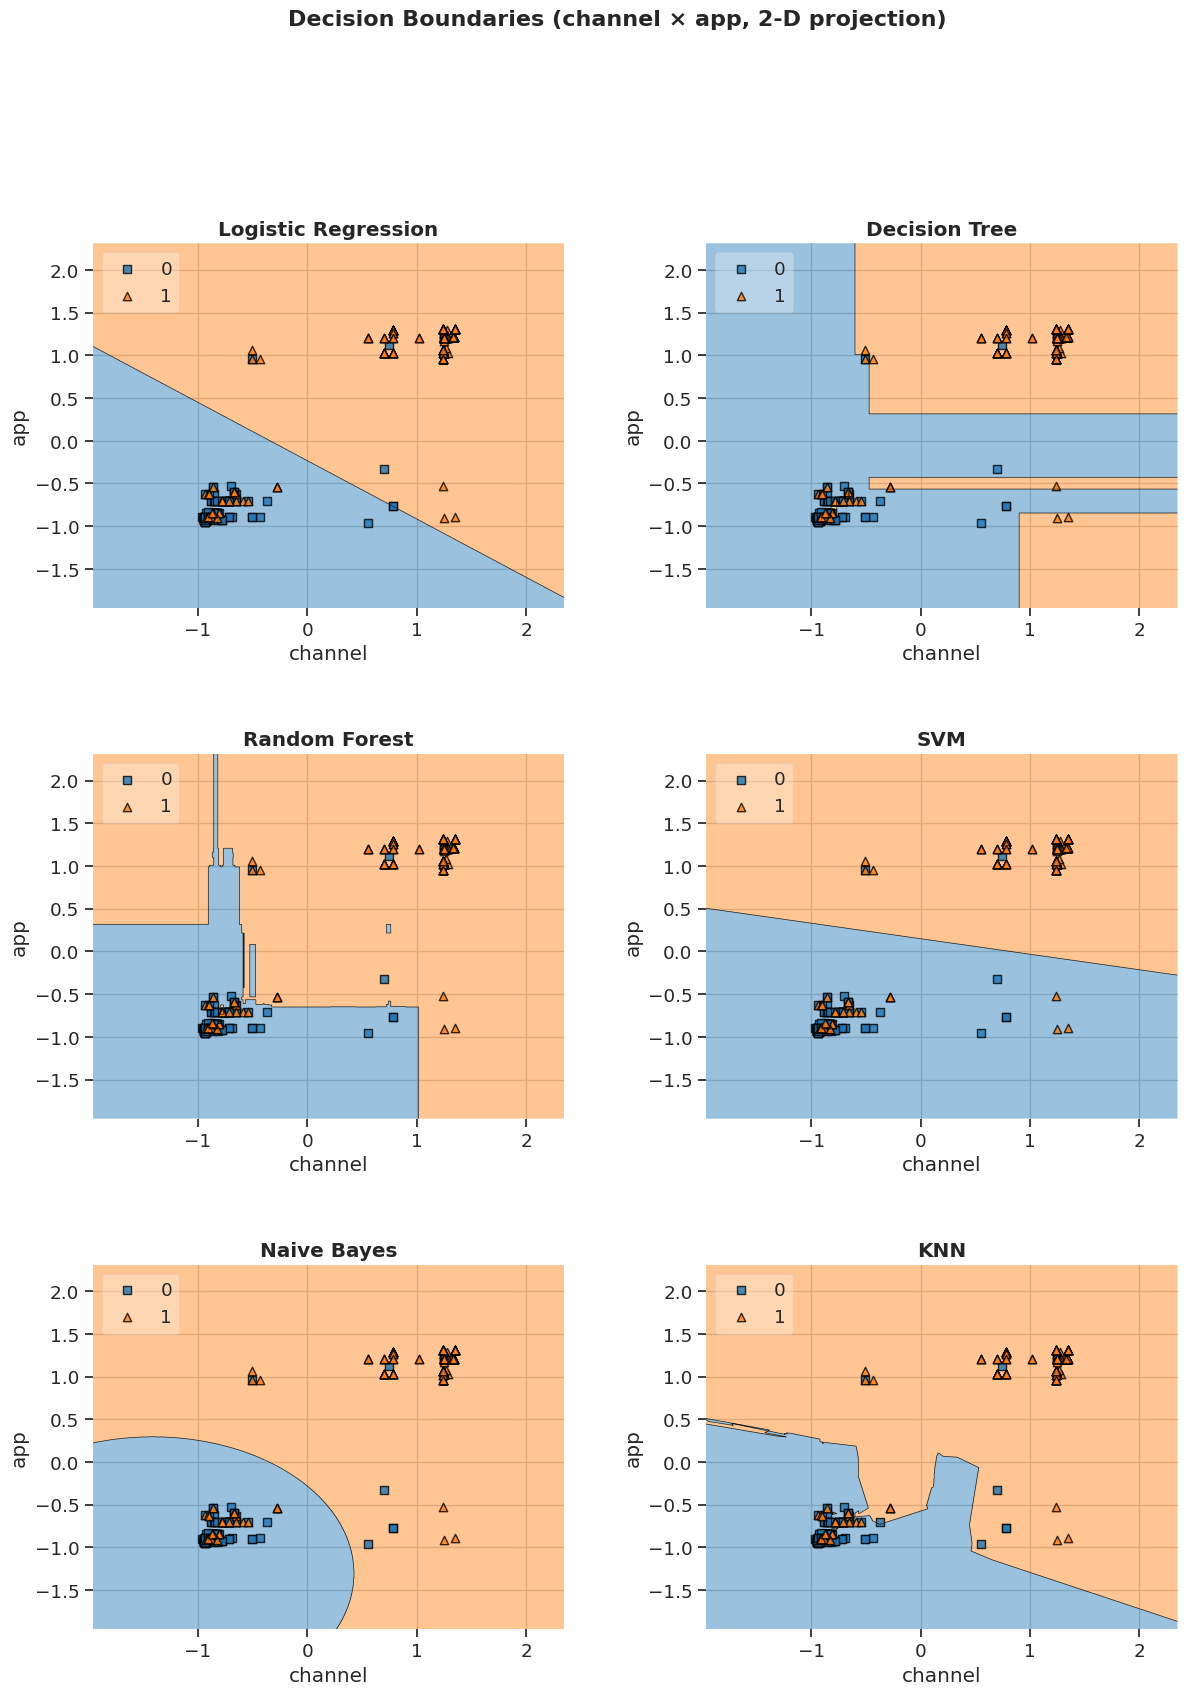

In [29]:
from mlxtend.plotting import plot_decision_regions

# Tiny subsample so mlxtend can render quickly
DB_SAMPLE = 400
feat_cols_2d = ['channel', 'app']

db_df = pd.DataFrame(balanced_x_scaled, columns=X.columns)
db_df['target'] = balanced_y.values
db_sub = pd.concat([
    db_df[db_df['target'] == 0].sample(DB_SAMPLE // 2, random_state=SEED),
    db_df[db_df['target'] == 1].sample(DB_SAMPLE // 2, random_state=SEED)
])

X_2d = db_sub[feat_cols_2d].to_numpy()
y_2d = db_sub['target'].to_numpy().astype(int)

clf_2d_list = [
    ('Logistic Regression', LogisticRegression(max_iter=500, random_state=SEED)),
    ('Decision Tree',       DecisionTreeClassifier(max_depth=5, random_state=SEED)),
    ('Random Forest',       RandomForestClassifier(n_estimators=50, max_depth=5, random_state=SEED)),
    ('SVM',                 SVC(kernel='linear', random_state=SEED)),
    ('Naive Bayes',         GaussianNB()),
    ('KNN',                 KNeighborsClassifier(n_neighbors=best_k)),
]

gs  = gridspec.GridSpec(3, 2, hspace=0.4, wspace=0.3)
fig = plt.figure(figsize=(14, 18))
fig.suptitle('Decision Boundaries (channel × app, 2-D projection)',
             fontsize=16, fontweight='bold', y=1.01)

for idx, (name, clf) in enumerate(clf_2d_list):
    clf.fit(X_2d, y_2d)
    ax = plt.subplot(gs[idx // 2, idx % 2])
    plot_decision_regions(X_2d, y_2d, clf=clf, legend=2, ax=ax)
    ax.set_title(name, fontweight='bold')
    ax.set_xlabel(feat_cols_2d[0])
    ax.set_ylabel(feat_cols_2d[1])

plt.tight_layout()
plt.savefig('/kaggle/working/decision_boundaries.png', dpi=150, bbox_inches='tight')
plt.show()